##### Loading the data

In [13]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
# Part of CSE 6242 GaTech research project 
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
test = pd.read_csv("california_labeled_formatted_tweets_split0.txt", sep='\t')
test.head()

,day,month,year,hour,minute,second,lat,long,tweet,category
0,24,8,2014,20,40,22,39.540305,-122.394197,RT @bgittleson: This photo is very California....,other_useful_information
1,24,8,2014,20,40,54,38.389855,-123.504200,Photos show earthquake devastation in Napa win...,infrastructure_and_utilities_damage
2,24,8,2014,20,40,26,38.111685,-122.747191,RT @dekebridges: 6.0 magnitude earthquake hits...,injured_or_dead_people
3,24,8,2014,20,41,0,39.187269,-123.033301,RT @GavinNewsom: Wow! Just some of the the dam...,infrastructure_and_utilities_damage
4,24,8,2014,20,40,42,38.118232,-121.309568,"Okay, if you live in Napa Valley California, w...",other_useful_information


##### Exploration

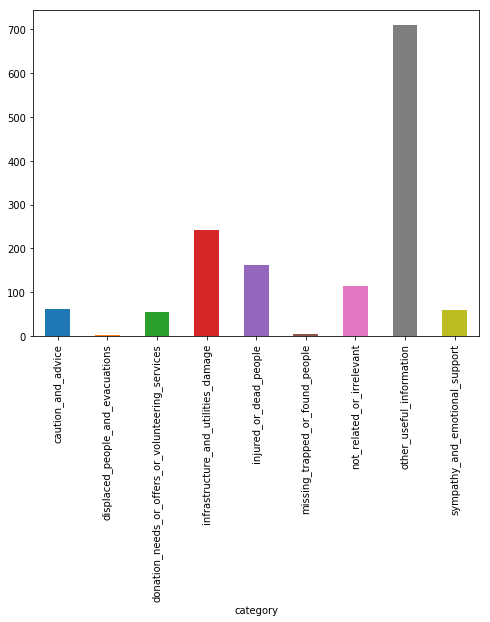

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
test.groupby('category').tweet.count().plot.bar(ylim=0)
plt.show()

We can see that "other useful information" seems to be a majority of the tweets. This isn't a show stopper though, we will proceed to make predictions on the data, keeping this category. Infastructure and utilities damage and injured or dead people  are other prominent categories which will be useful to for our analysis. 

#### Building training set 

In [28]:
trainDF = pd.DataFrame()
trainDF['text'] = test['tweet']
trainDF['label'] = test['category']
trainDF.head()

,text,label
0,RT @bgittleson: This photo is very California....,other_useful_information
1,Photos show earthquake devastation in Napa win...,infrastructure_and_utilities_damage
2,RT @dekebridges: 6.0 magnitude earthquake hits...,injured_or_dead_people
3,RT @GavinNewsom: Wow! Just some of the the dam...,infrastructure_and_utilities_damage
4,"Okay, if you live in Napa Valley California, w...",other_useful_information


In [37]:
tweetsList = trainDF['text'].tolist()
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = re.sub(r"http\S+", "", normalized)
    return result

tweetsList_clean = [clean(tweet).split() for tweet in tweetsList]  
combined = [' '.join(tweet) for tweet in tweetsList_clean]
trainDF['text'] = combined
trainDF.head()

,text,label
0,rt bgittleson photo california napa earthquake,other_useful_information
1,photo show earthquake devastation napa wine co...,infrastructure_and_utilities_damage
2,rt dekebridges 60 magnitude earthquake hit nor...,injured_or_dead_people
3,rt gavinnewsom wow damage napaquake city amp h...,infrastructure_and_utilities_damage
4,okay live napa valley california let little 60...,other_useful_information


In [38]:
from io import StringIO
col = ['label', 'text']
df = trainDF[col]
df = df[pd.notnull(df['text'])]
df.columns = ['label', 'text']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df.head()

,label,text,category_id
0,other_useful_information,rt bgittleson photo california napa earthquake,0
1,infrastructure_and_utilities_damage,photo show earthquake devastation napa wine co...,1
2,injured_or_dead_people,rt dekebridges 60 magnitude earthquake hit nor...,2
3,infrastructure_and_utilities_damage,rt gavinnewsom wow damage napaquake city amp h...,1
4,other_useful_information,okay live napa valley california let little 60...,0


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(1408, 832)

Now each of the 1408 tweets is represented by 832 features, representing teh tf-idf score for different unigrams and bigrams

In [27]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'caution_and_advice':
  . Most correlated unigrams:
. jimsciutto
. sent
  . Most correlated bigrams:
. rt jimsciutto
. earthquake rattle
# 'displaced_people_and_evacuations':
  . Most correlated unigrams:
. rattle
. usatoday
  . Most correlated bigrams:
. napa winery
. rt usatoday
# 'donation_needs_or_offers_or_volunteering_services':
  . Most correlated unigrams:
. review
. biggest
  . Most correlated bigrams:
. biggest quake
. hit california
# 'infrastructure_and_utilities_damage':
  . Most correlated unigrams:
. human
. big
  . Most correlated bigrams:
. valley winery
. critically injured
# 'injured_or_dead_people':
  . Most correlated unigrams:
. sonoma
. watching
  . Most correlated bigrams:
. earthquake damage
. earthquake amp
# 'missing_trapped_or_found_people':
  . Most correlated unigrams:
. abc7
. death
  . Most correlated bigrams:
. earthquake rattle
. south napa
# 'not_related_or_irrelevant':
  . Most correlated unigrams:
. mobile
. park
  . Most correlated bigrams:
. rt 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

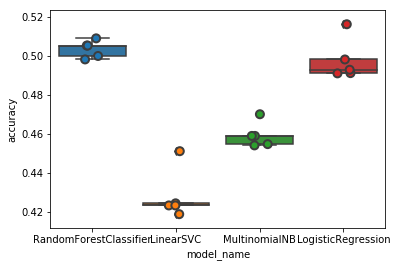

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [11]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.428363
LogisticRegression        0.497951
MultinomialNB             0.459485
RandomForestClassifier    0.503589
Name: accuracy, dtype: float64

In [12]:
print(set(test['category']))

{'caution_and_advice', 'not_related_or_irrelevant', 'sympathy_and_emotional_support', 'missing_trapped_or_found_people', 'donation_needs_or_offers_or_volunteering_services', 'displaced_people_and_evacuations', 'infrastructure_and_utilities_damage', 'injured_or_dead_people', 'other_useful_information'}
